In [1]:
# Import required packages
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rasterio as rio
import pandas as pd
import earthpy.plot as ep

# Set font sizes for plots
plt.rc('figure', titlesize=24)
plt.rc('axes', titlesize=16)

# Set area of interest and define paths
aoi = "koumassi_focus_ps"
band_path = '..\\data\\'+aoi+"\\"
combined_path = '..\\data\\combined\\'
threshold_outputs_path = os.path.join(band_path, "outputs\\threshold\\")
svm_outputs_path = os.path.join(band_path, "outputs\\svm\\")
kmeans_outputs_path = os.path.join(band_path, "outputs\\kmeans\\")

 ## Out of the Shadows
 
 ### *Improving flood detection in urban environments by separating building shadows from flood waters*

Over the past 20 years, floods accounted for 43% of all recorded disasters. In that same time period, more than two billion people were affected by flooding events, including over 140,000 deaths, and economic losses amounting to $656M USD. Flooding events are expected to increase in frequency and extent due to the impacts of climate change, including heavy precipitation events, rapid spring snowmelt, and dramatic storm surge. In urban areas, flooding is exacerbated by the presence of impermeable cement surfaces and ineffective drainage systems. In the next 30 years, the urban population is expected to grow by an additional 2.5 billion people, with the majority of growth centered in Africa and Asia.

While it is difficult to predict where the next flooding disaster may strike, preparedness is key to mitigating the extent of the damage. Traditional flood mapping is an extensive and expensive endeavor, involving teams of engineers, modelers, and field personnel working on just one specific location. Due to the resources required to develop these maps, many communities, especially those in low- and middle-income countries, do not have adequate maps or rely on maps which are out of date. This lack of up-to-date information means that residents and businesses located within a potential flood plain may not realize that they are at risk, and are unable to take steps to protect themselves and their property. 

Remote sensing, and specifically the availability of high-resolution satellite imagery, which can provide detailed aerial views of cities, offers a new way to examine floods and define risk. Historical images can be rapidly analyzed to give a sense of frequency and extent of natural disasters such as floods. This information can be used to develop low-cost flood maps which can be used to ensure all residents of the potential flood plain are identified and updated regularly. Additionally, near real-time monitoring of natural disasters is possible as satellites provide regularly updated images on a relatively short time-scale.

The conventional method for analyzing open water on satellite imagery is through using the normalized difference water index (NDWI), a ratio of the near-infrared radiation and visible green light spectral bands. A challenge in assessing open water in an urban environment is that buildings can interfere with the NDWI signal. The modified NDWI (MNDWI) was developed specifically to address this interference, and utilizes short-wave infrared radiation (SWIR) in place of near-infrared radiation. However, high-resolution imagery from satellites such as DigitalGlobe’s WorldView-2 often lack the SWIR band, rendering the MNDWI calculation impossible. Organizations working in identifying urban flooding have sought to identify a variety of image-specific algorithms that utilize combinations of spectral bands and indices have had mixed success. One of the remaining challenges in defining urban flood extent is confusion between cloud and building shadows and flood waters, which look visually similar and can be miscategorized. 

In partnership with Cloud to Street, a company focused on providing flood information to low- and middle-income countries, this research aimed to explore Python-based methods to improve the detection of floods in urban environments, with a specific focus on better differentiating between building shadow and flood water. The study image was a WorldView-2 image from a flooding event in Abidjan, Ivory Coast on June 17th, 2016. Two sub-sections of the city were selected as focus areas. The first, in the Koumassi region of the city represented a highly urban area. The second, in the southeastern section of the city, represented lower lying wetland terrain. Each method was validated using a reference data set. Several methods were explored:

-	Thresholding spectral indices
-	Supervised machine learning
        - Random Forest (RF)
        - Support Vector Machine (SVM)
-	Unsupervised machine learning
        - K-means
        - Gaussian mixture modeling (GMM)

## Traditional Thresholding Approach

The first approach involved thresholding established spectral indices to identify water, building shadow, vegetation and buildings. Thresholding is a trial and error method and the chosen thresholds are generally image specific, meaning that the process must be done for each image of interest. The resulting threshold map had an accuracy score of 59.3%. 

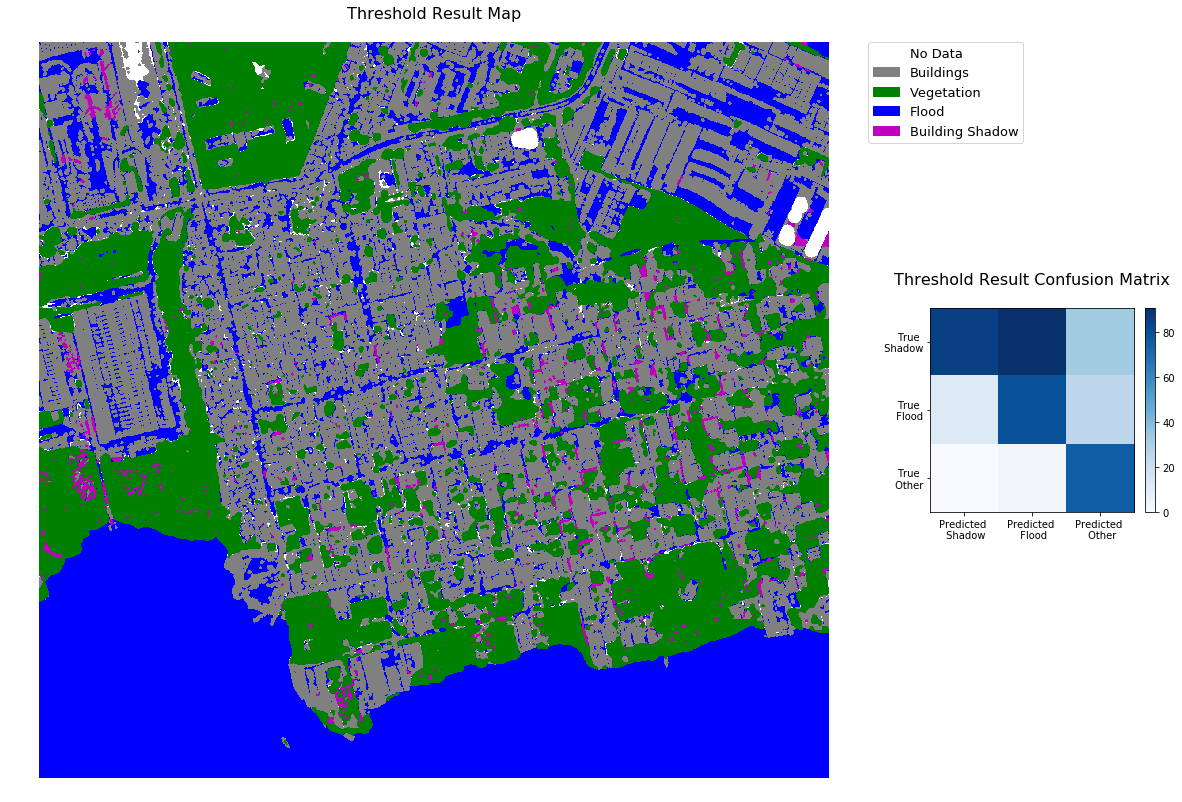

In [12]:
# Import threshold map and confusion matrix for plotting
threshold_path = os.path.join(
    threshold_outputs_path, "index_comb_yellow.tif")
with rio.open(threshold_path) as src:
    threshold_map = src.read()
threshold_map = np.squeeze(threshold_map)

confusion_df = pd.read_csv(threshold_outputs_path+'threshold_confusion_40.csv')
confusion_df = confusion_df.drop(confusion_df.columns[[0]], axis=1)
confusion_plot = confusion_df.values

# Plot threshold map and confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(
    20, 15), gridspec_kw={'width_ratios': [3.5, 1]})
cmap = ListedColormap(['white', 'grey', 'green', 'blue', 'm'])
labels = ['No Data', 'Buildings', 'Vegetation', 'Flood', 'Building Shadow']
map_plot = ax1.imshow(threshold_map, cmap=cmap)
ep.draw_legend(map_plot, titles=labels)
ax1.set_axis_off()
conf_mat = ax2.imshow(confusion_plot, cmap='Blues', interpolation='nearest')
ax1.set(title="Threshold Result Map\n")
ax2.set(title="Threshold Result Confusion Matrix\n")
plt.setp(ax2, xticks=np.arange(3), xticklabels=['Predicted \n Shadow', 'Predicted \n Flood', 'Predicted \n Other'],
         yticks=np.arange(3), yticklabels=['True \n Shadow', 'True \n Flood', 'True \n Other'])
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(conf_mat, cax=cax1)

plt.show()

**Figure 1.** The threshold result map shows the extent of flooding within the study area, along with areas of building shadow, vegetation and buildings. The confusion matrix shows that shadow is frequently miscategorized as flood water in the validation process. 

## Supervised Machine Learning

Supervised machine learning approaches were examined next, utilizing both Random Forest and Support Vector Machine classifiers. Inputs to the models were selected after exploring various combinations of raw spectral bands and index values. Supervised machine learning methods require a training data set, with known values for the classes of interest to define the model. In this case, developing a training data set required a detailed examination of the satellite image, with training points dropped on specific locations to identify building shadow and flood. Selecting model inputs and developing training data can be time intensive and is a reminder that despite the power of machine learning methods, human inputs are imperative! Once the models were trained and refined, they were validated on an external data set. Accuracy scores for the external validation were 95.3% and 91.8% for Support Vector Machine and Random Forest, respectively. Results for the supervised methods are promising and present a substantial improvement over the thresholding approach.

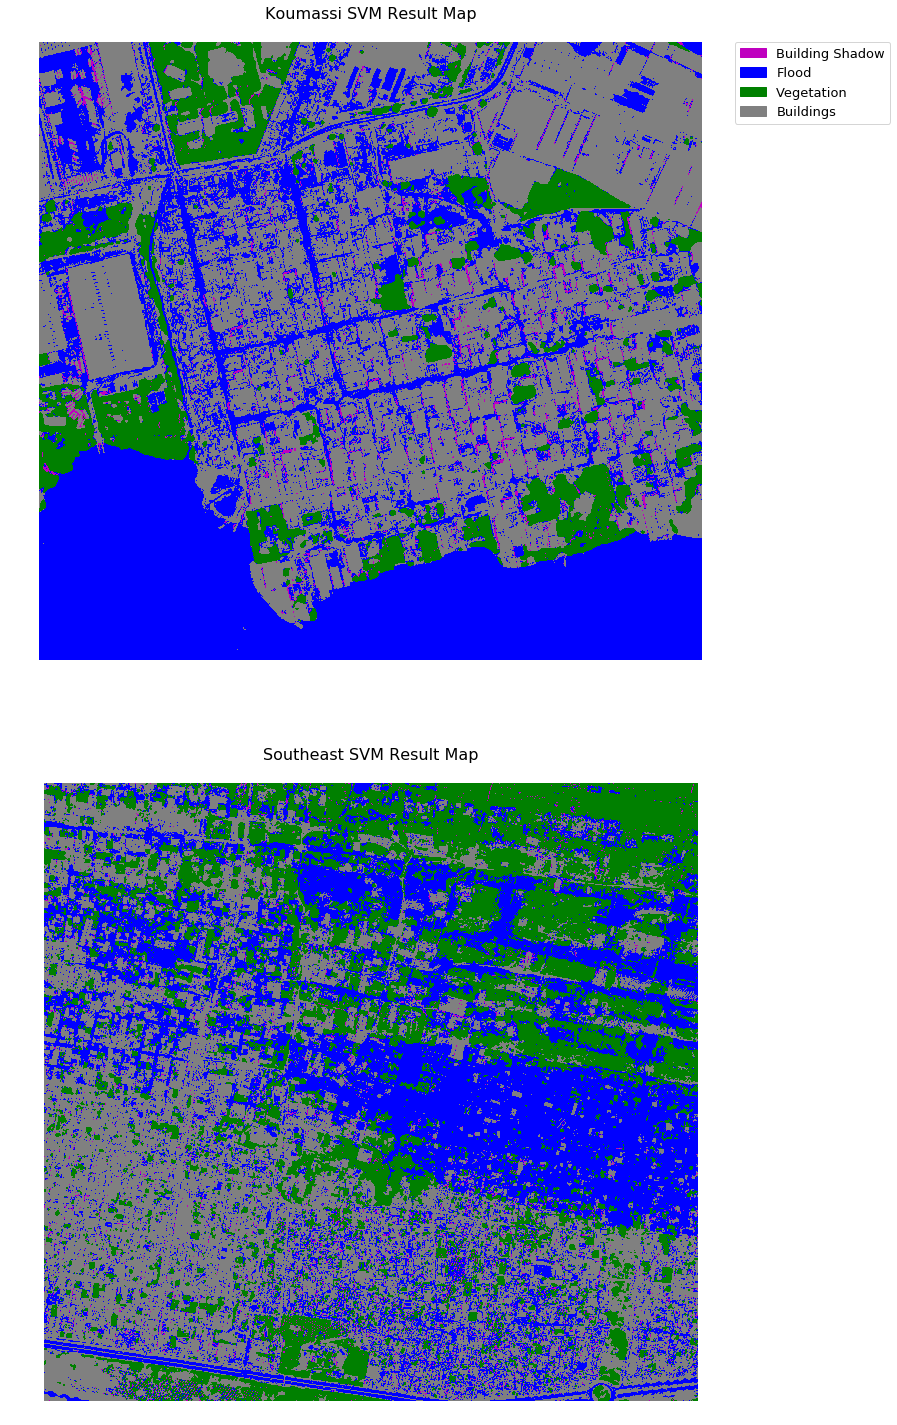

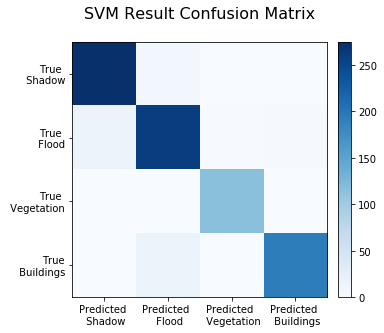

In [27]:
# Import SVM map and confusion matrix for plotting
koumassi_svm_path = os.path.join(
    combined_path, "koumassi_SVM_map_combined_424.tif")
with rio.open(koumassi_svm_path) as src:
    koumassi_svm_map = src.read()
koumassi_svm_map = np.squeeze(koumassi_svm_map)

southeast_svm_path = os.path.join(
    combined_path, "southeast_SVM_map_combined_424.tif")
with rio.open(southeast_svm_path) as src:
    southeast_svm_map = src.read()
southeast_svm_map = np.squeeze(southeast_svm_map)

confusion_svm = pd.read_csv(combined_path+'confusion_svm_external_424.csv')
confusion_svm = confusion_svm.drop(confusion_svm.columns[[0]], axis=1)
confusion_svm_plot = confusion_svm.values


# Plot SVM maps 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(
    30, 25))
cmap = ListedColormap(['m', 'blue', 'green','grey'])
labels = ['Building Shadow', 'Flood', 'Vegetation', 'Buildings']
im = ax1.imshow(koumassi_svm_map, cmap=cmap)
im2 = ax2.imshow(southeast_svm_map, cmap=cmap)
ax1.set(title="Koumassi SVM Result Map\n")
ax2.set(title="Southeast SVM Result Map\n")
ep.draw_legend(im, titles=labels)
fig.colorbar(conf_mat, cax=cax1)
ax1.set_axis_off()
ax2.set_axis_off()
plt.show()

# # Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
plt.setp(ax, xticks=np.arange(4), xticklabels=['Predicted \n Shadow', 'Predicted \n Flood', 'Predicted \n Vegetation','Predicted \n Buildings'],
         yticks=np.arange(4), yticklabels=['True \n Shadow', 'True \n Flood', 'True \n Vegetation','True\n Buildings'])
conf_mat = ax.imshow(confusion_svm_plot, cmap='Blues',
                      interpolation='nearest')
ax.set(title="SVM Result Confusion Matrix\n")
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(conf_mat, cax=cax1)
plt.show()

**Figure 2.** The SVM result map shows the modeled extent of flooding within the study area, along with areas of building shadow, and other classes (vegetation and buildings). The confusion matrix shows that shadow is accurately predicted, while there is some miscategorization of flood water as shadow.  

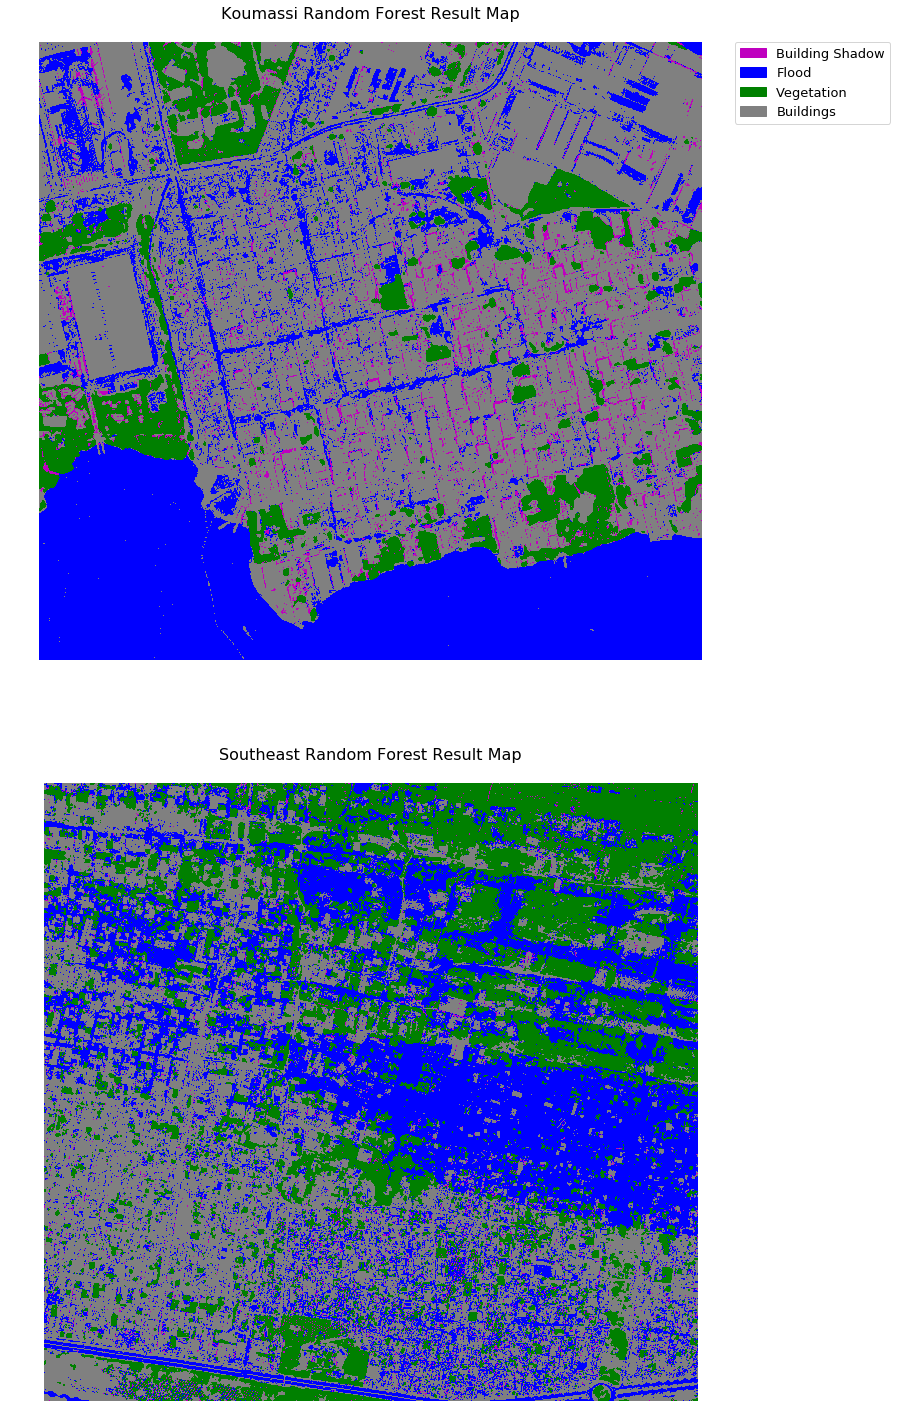

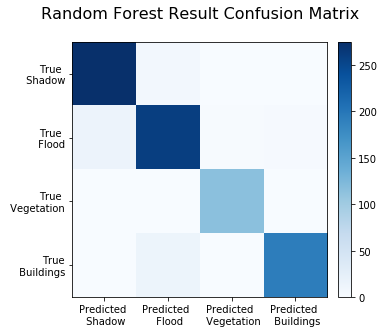

In [29]:
# Import RF map and confusion matrix for plotting
koumassi_rf_path = os.path.join(
    combined_path, "koumassi_RF_map_combined_424.tif")
with rio.open(koumassi_rf_path) as src:
    koumassi_rf_map = src.read()
koumassi_rf_map = np.squeeze(koumassi_rf_map)

southeast_rf_path = os.path.join(
    combined_path, "southeast_RF_map_combined_424.tif")
with rio.open(southeast_rf_path) as src:
    southeast_rf_map = src.read()
southeast_rf_map = np.squeeze(southeast_rf_map)

confusion_rf = pd.read_csv(combined_path+'confusion_rf_external_424.csv')
confusion_rf = confusion_rf.drop(confusion_rf.columns[[0]], axis=1)
confusion_rf_plot = confusion_rf.values


# Plot SVM maps 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(
    30, 25))
cmap = ListedColormap(['m', 'blue', 'green','grey'])
labels = ['Building Shadow', 'Flood', 'Vegetation', 'Buildings']
im = ax1.imshow(koumassi_rf_map, cmap=cmap)
im2 = ax2.imshow(southeast_rf_map, cmap=cmap)
ax1.set(title="Koumassi Random Forest Result Map\n")
ax2.set(title="Southeast Random Forest Result Map\n")
ep.draw_legend(im, titles=labels)
fig.colorbar(conf_mat, cax=cax1)
ax1.set_axis_off()
ax2.set_axis_off()
plt.show()

# # Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
plt.setp(ax, xticks=np.arange(4), xticklabels=['Predicted \n Shadow', 'Predicted \n Flood', 'Predicted \n Vegetation','Predicted \n Buildings'],
         yticks=np.arange(4), yticklabels=['True \n Shadow', 'True \n Flood', 'True \n Vegetation','True\n Buildings'])
conf_mat = ax.imshow(confusion_svm_plot, cmap='Blues',
                      interpolation='nearest')
ax.set(title="Random Forest Result Confusion Matrix\n")
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(conf_mat, cax=cax1)
plt.show()

**Figure 3.** The random forest result map shows the extent of flooding within the study area, along with areas of building shadow, and other classes (vegetation and buildings). The confusion matrix shows that shadow is accurately predicted, while there is some miscategorization of flood waters.  

## Unsupervised Machine Learning
Finally, unsupervised machine learning approaches includes k-means and the Gaussian Mixture Model were explored. Both methods do not require any training data sets, and instead find similarities within the inputs, and automatically output clusters. The input for these two methods was the eight-band raster stack. K-means had an accuracy score of 82.8% and GMM a score of 44.2%. While the k-means outputs are promising,the GMM method did not capture the difference between shadow and flood waters. While the k-means accuracy score was not as high as the supervised machine learning models, it also did not require a training data set to develop, meaning that substantially less effort is required to use these unsupervised approaches!

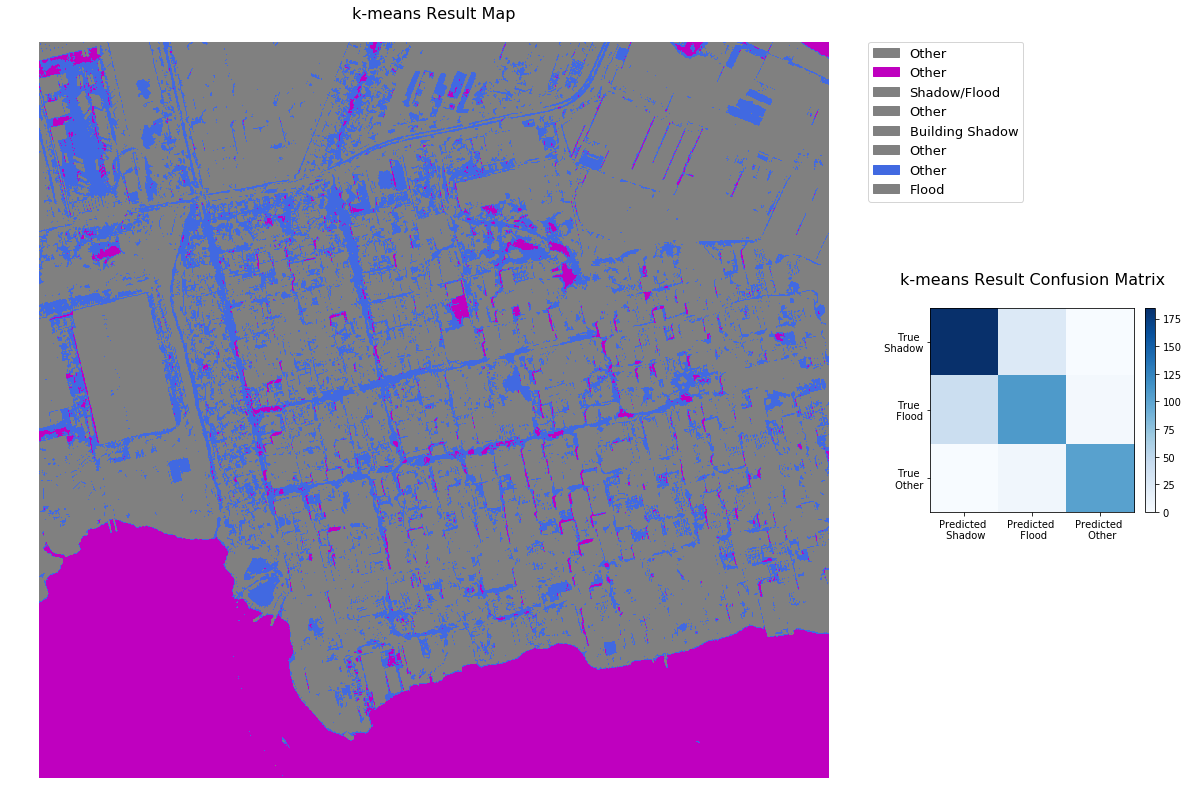

In [5]:
# Plot showing kmeans results
kmeans_path = os.path.join(
    kmeans_outputs_path, "kmeans_all_bands.tif")
with rio.open(kmeans_path) as src:
    kmeans_map = src.read()
kmeans_map = np.squeeze(kmeans_map)


confusion_kmeans = pd.read_csv(kmeans_outputs_path+'kmeans_confusion_40.csv')
confusion_kmeans = confusion_kmeans.drop(confusion_kmeans.columns[[0]], axis=1)
confusion_kmeans_plot = confusion_kmeans.values


# Plot kmeans map and confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(
    20, 15), gridspec_kw={'width_ratios': [3.5, 1]})
cmap = ListedColormap(['grey', 'm', 'grey', 'grey',
                       'grey', 'grey', 'royalblue', 'grey'])
plt.setp(ax2, xticks=np.arange(3), xticklabels=['Predicted \n Shadow', 'Predicted \n Flood', 'Predicted \n Other'],
         yticks=np.arange(3), yticklabels=['True \n Shadow', 'True \n Flood', 'True \n Other'])
labels = ['Other', 'Other', 'Shadow/Flood', 'Other',
          'Building Shadow', 'Other', 'Other', 'Flood']
im = ax1.imshow(kmeans_map, cmap=cmap)
conf_mat = ax2.imshow(confusion_kmeans_plot,
                      cmap='Blues', interpolation='nearest')
ax1.set(title="k-means Result Map\n")
ax2.set(title="k-means Result Confusion Matrix\n")
ep.draw_legend(im, titles=labels)
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(conf_mat, cax=cax1)
ax1.set_axis_off()
plt.show()

**Figure 4.** The k-means result map shows the modeled extent of flooding within the study area, along with areas of building shadow, and other classes (vegetation and buildings). The k-means model resulted in 8 clusters, with all clusters other than those capturing building shadow and flood classified as "other". The dark blue cluster shows that both shadow and flood are captured within the same cluster. The confusion matrix also shows miscategorization for both shadow and flood. 

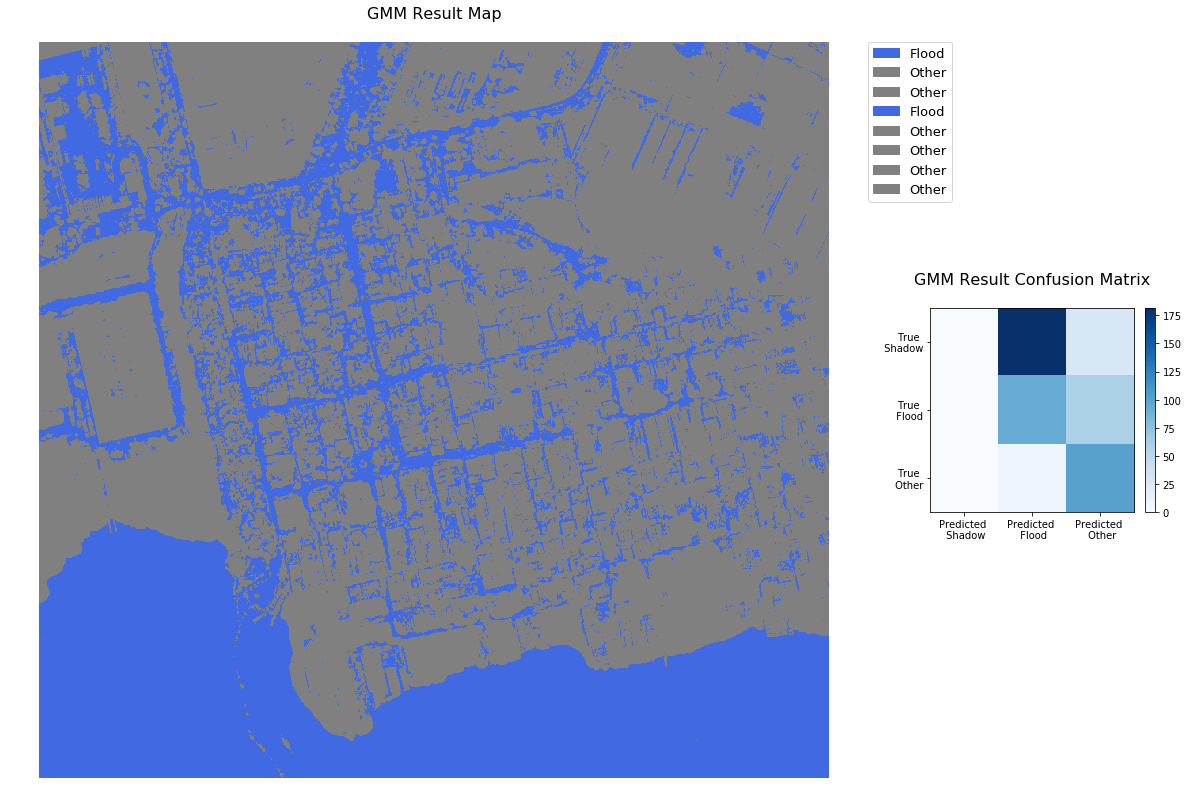

In [6]:
# Plot showing GMM results
gmm_path = os.path.join(
    kmeans_outputs_path, "gmm_all_bands.tif")
with rio.open(gmm_path) as src:
    gmm_map = src.read()
gmm_map = np.squeeze(gmm_map)


confusion_gmm = pd.read_csv(
    kmeans_outputs_path+'gmm_all_bands_confusion_40.csv')
confusion_gmm = confusion_gmm.drop(confusion_gmm.columns[[0]], axis=1)
confusion_gmm_plot = confusion_gmm.values


# Plot kmeans map and confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(
    20, 15), gridspec_kw={'width_ratios': [3.5, 1]})
cmap = ListedColormap(['royalblue', 'grey', 'grey', 'royalblue',
                       'grey', 'grey', 'grey', 'grey'])
plt.setp(ax2, xticks=np.arange(3), xticklabels=['Predicted \n Shadow', 'Predicted \n Flood', 'Predicted \n Other'],
         yticks=np.arange(3), yticklabels=['True \n Shadow', 'True \n Flood', 'True \n Other'])
labels = ['Flood', 'Other', 'Other', 'Flood',
          'Other', 'Other', 'Other', 'Other']
im = ax1.imshow(gmm_map, cmap=cmap)
conf_mat = ax2.imshow(confusion_gmm_plot,
                      cmap='Blues', interpolation='nearest')
ax1.set(title="GMM Result Map\n")
ax2.set(title="GMM Result Confusion Matrix\n")
ep.draw_legend(im, titles=labels)
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
fig.colorbar(conf_mat, cax=cax1)
ax1.set_axis_off()
plt.show()

**Figure 5.** The GMM result map show the modeled extent of flooding within the study area, along with areas of building shadow, and other classes (vegetation and buildings). The GMM model resulted in clusters, with all clusters other than those capturing building shadow and flood classified as "other". The magenta cluster shows that both shadow and flood are captured within the same cluster. The confusion matrix also shows miscategorization for both shadow and flood. Input to the k-means model was the 8-band stack which had been cloud masked, plus a shadow mask layer. 

# Why is this important?
The machine learning models were each developed on a small subsection of the city. The model with the highest accuracy score, the support vector machine (SVM) model, was then applied to the entire flooded city image. Results appear promising, though the map has not been validated. By spending time developing a training data set on a representative portion of a city, a good approximation of flooding extent for a much larger area appears possible. 

In [7]:
# Plot result of RF being applied to entire city
rf_extended_path = os.path.join(
    svm_outputs_path, "mosaic_bbox_cloudmask_applied_rf.tif")
with rio.open(rf_extended_path) as src:
    rf_map_extended = src.read()
rf_map_extended = np.squeeze(rf_map_extended)

# Will update with revised SVM image.

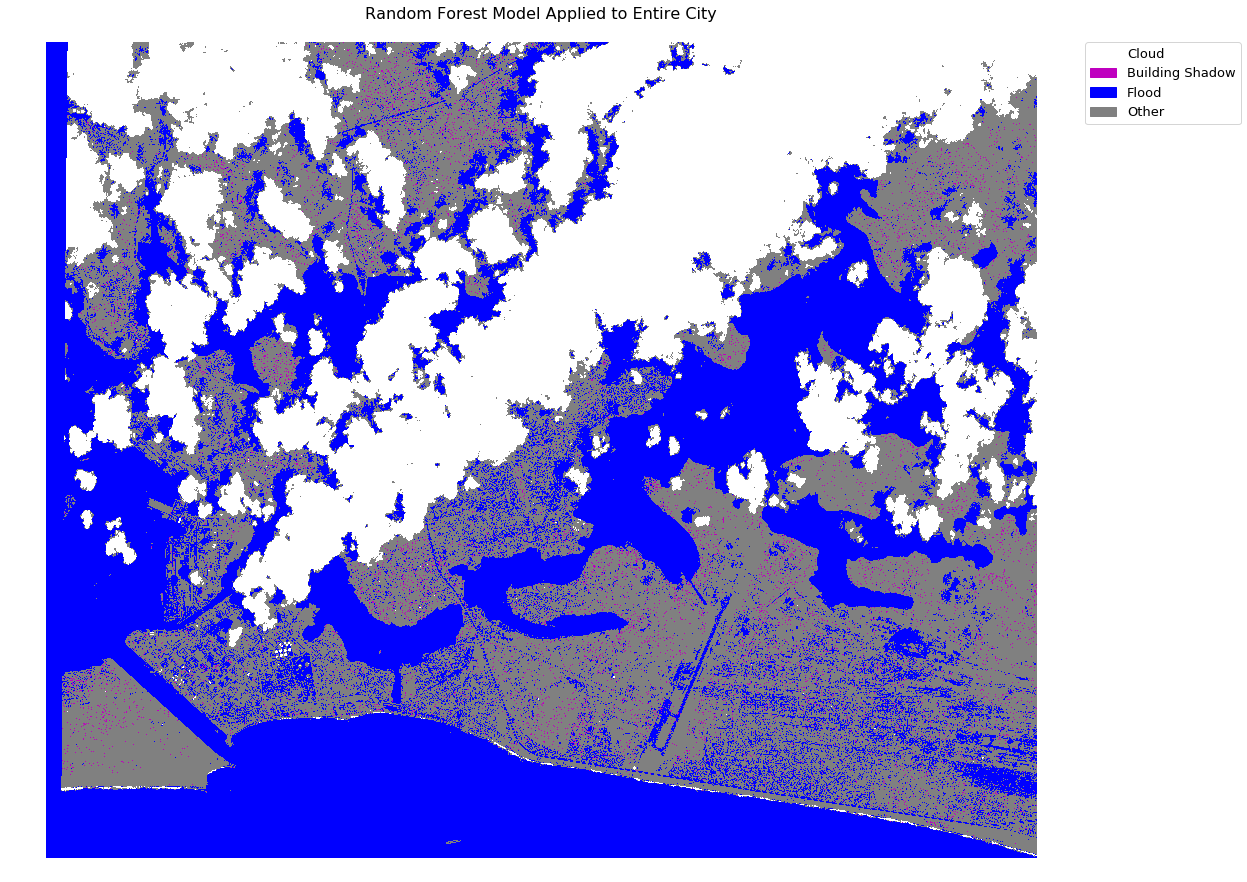

In [8]:
# Plot random forest map for entire city
fig, ax = plt.subplots(figsize=(20, 15))
cmap = ListedColormap(['white','m', 'blue', 'grey'])
labels = ['Cloud','Building Shadow', 'Flood', 'Other']
im_ext = ax.imshow(rf_map_extended, cmap=cmap)
ax.set(title="Random Forest Model Applied to Entire City\n")
ep.draw_legend(im_ext, titles=labels)
ax.set_axis_off()
plt.show()

**Figure 6.** The support vectorm machine (SVM) model shows flooding throughout the city, especially in the southeastern section of the city. This map has not been validated, but offers an interesting glimpse into the potential for developing a detailed supervised model on a representative subsection of a larger image, and then applying it to the greater image.

The machine learning methods explored in this study appear to offer additional and more accurate information beyond the traditional thresholding result, with a similar (or lesser!) level of effort. Improvements to the flood plain mapping process means that decision makers can have the best information possible when planning developments, zoning areas of the city, and offering insurance to residents. Better informaton means that more people can be better prepared and protected from the potential damage from floods.

# Future Work
Future work includes incorporating a building layer from a source such as Open Street Map, expanding the urban model which includes both buildings and surrounding low-lying wetlands and agricultural terrain and testing the validated models to see how applicable they are for other flooded urban areas. 

For more details, check out my [Flood Detection GitHub repository](http://www.github.com/katysill/flood-detection)

### References


- Cloud to Street. Urban Flood Mapping Using Very-High Resolution Satellite Imagery. Available at: https://abidjan.cloudtostreet.info/info

- Huang, X., Xie, C., Fang, X., Zhang, L. (2015) Combining Pixel-and Object-Based Machine Learning for Identification of Water-Body Types from Urban High-Resolution Remote-Sensing Imagery. IEEE J. Sel. Top. Appl. Earth Obs. Remote Sens. 8, 2097–2110.

- Huang, X., and Zhang, L. (2012) Morphological Building/Shadow Index for Building Extraction From High-Resolution Imagery Over Urban Areas. IEEE J. Sel. Top. Appl. Earth Obs. Remote Sens. 5, 161-172.

- McFeeters, S.K. (1996) The use of the Normalized Difference Water Index (NDWI) in the delineation of open water features, International Journal of Remote Sensing, 17:7, 1425-1432, DOI: 10.1080/01431169608948714

- United Nations Office for Disaster Risk Reduction (UNISDR) and Centre for Research on the Epidemiology of Disasters (CRED) (2018). Economic losses, poverty & disasters: 1998-2017. Available at: https://www.preventionweb.net/files/61119_credeconomiclosses.pdf

- Xie, C., Huang, X., Zeng, W., & Fang, X. (2016). A novel water index for urban high-resolution eight-band WorldView-2 imagery. International Journal of Digital Earth, 9(10), 925–941.

- Xu, H. (2006). Modification of normalised difference water index (NDWI) to enhance open water features in remotely sensed imagery. International Journal of Remote Sensing. Vol. 27, No. 14, 3025–3033.